In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import openmc
import os
import openmc.deplete
import psutil

from IPython.display import Image
from openmc import Plot
from dotenv import load_dotenv

load_dotenv()

CROSS_SECTIONS = os.getenv('CROSS_SECTIONS')
CHAIN_FILE = os.getenv('CHAIN_FILE')

openmc.config['cross_sections'] = CROSS_SECTIONS
openmc.config['chain_file'] = CHAIN_FILE

[sebastian-TUF-Gaming-FX505GT:15167] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.sebastian-TUF-Gaming-FX505GT.1000/jf.0/132317184/shared_mem_cuda_pool.sebastian-TUF-Gaming-FX505GT could be created.
[sebastian-TUF-Gaming-FX505GT:15167] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


In [2]:
# Define materials
# 1.6% enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide('U235', 3.7503e-4)
fuel.add_nuclide('U238', 2.2625e-2)
fuel.add_nuclide('O16', 4.6007e-2)
fuel.volume = 100.0

# Borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide('H1', 4.9457e-2)
water.add_nuclide('O16', 2.4732e-2)
water.add_nuclide('B10', 8.0042e-6)

# Zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide('Zr90', 7.2758e-3)

In [3]:
# Instantiate a Materials collection
materials = openmc.Materials([fuel, water, zircaloy])

# Export to "materials.xml"
materials.export_to_xml()

In [4]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, r=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-0.63, boundary_type='reflective')
max_x = openmc.XPlane(x0=+0.63, boundary_type='reflective')
min_y = openmc.YPlane(y0=-0.63, boundary_type='reflective')
max_y = openmc.YPlane(y0=+0.63, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-0.63, boundary_type='reflective')
max_z = openmc.ZPlane(z0=+0.63, boundary_type='reflective')

In [5]:
# Create Universe for the fuel pin and cells
pin_cell_universe = openmc.Universe(name='1.6% Fuel Pin')

# Add Cells to the pin universe
fuel_cell = openmc.Cell(name='1.6% Fuel', fill=fuel, region=-fuel_outer_radius)
pin_cell_universe.add_cell(fuel_cell)

clad_cell = openmc.Cell(name='1.6% Clad', fill=zircaloy, region=+fuel_outer_radius & -clad_outer_radius)
pin_cell_universe.add_cell(clad_cell)

moderator_cell = openmc.Cell(name='1.6% Moderator', fill=water, region=+clad_outer_radius)
pin_cell_universe.add_cell(moderator_cell)

In [6]:
# Create root Cell and Universe
root_cell = openmc.Cell(name='root cell', fill=pin_cell_universe)
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

In [7]:
# Create Geometry and set root Universe
geometry = openmc.Geometry(root_universe)

In [8]:
# Export to "geometry.xml"
geometry.export_to_xml()

In [9]:
# Create OpenMC settings
settings = openmc.Settings()

# Simulation parameters
settings.batches = 100
settings.inactive = 10
settings.particles = 5000  # Ensure this is properly set

# Create an initial uniform spatial source distribution over the geometry bounds
bounds = [-0.63, -0.63, -0.63, 0.63, 0.63, 0.63]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:])

# Define source using the distribution
source = openmc.IndependentSource(space=uniform_dist)

# Add the source to settings
# settings.source = source

# Export settings to XML
settings.export_to_xml()

In [10]:
# Set up mesh for tally
mesh = openmc.RegularMesh()
mesh.dimension = [100, 100]
mesh.lower_left = [-0.63, -0.63]
mesh.upper_right = [0.63, 0.63]

# Create mesh filter for tally
mesh_filter = openmc.MeshFilter(mesh)

In [11]:
# Create a tally to score flux and fission rate
tallies = openmc.Tallies()
tally = openmc.Tally(name='flux')
tally.filters = [mesh_filter]
tally.scores = ['flux', 'fission']
tallies.append(tally)

# Attach tallies to the model
model = openmc.Model()
model.materials = materials
model.geometry = geometry
model.tallies = tallies

In [12]:
# Export tallies to "tallies.xml"
tallies.export_to_xml()

In [13]:
# Set the number of particles and batches
model.settings.particles = 10000  # For example, set 10,000 particles
model.settings.batches = 100  # Set the number of batches to 100

# Ensure the settings are exported to the settings.xml
model.settings.export_to_xml()

# Define depletion operator and integrate
op = openmc.deplete.CoupledOperator(model)
power = 1200.0e6  # watts
timesteps = [0.1, 0.1, 0.1]  # days
integrator = openmc.deplete.PredictorIntegrator(op, timesteps, power)
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Mo92 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo92.h5
 Reading Mo94 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo94.h5
 Reading Mo95 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo95.h5
 Reading Mo96 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo96.h5
 Reading Mo97 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo97.h5
 Reading Mo98 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo98.h5
 Reading Mo99 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo99.h5


 Reading Mo100 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Mo100.h5
 Reading Tc99 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Tc99.h5
 Reading Ru100 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru100.h5
 Reading Ru101 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru101.h5
 Reading Ru102 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru102.h5
 Reading Ru103 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru103.h5
 Reading Ru104 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru104.h5
 Reading Ru105 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru105.h5
 Reading Ru106 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ru106.h5
 Reading Rh103 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Rh103.h5
 Reading Rh104 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Rh104.h5
 

 Reading I135 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/I135.h5
 Reading Xe128 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe128.h5
 Reading Xe130 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe130.h5
 Reading Xe131 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe131.h5
 Reading Xe132 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe132.h5
 Reading Xe133 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe133.h5
 Reading Xe134 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe134.h5
 Reading Xe135 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe135.h5
 Reading Xe136 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Xe136.h5


          2500K


 Reading Cs133 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Cs133.h5
 Reading Cs134 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Cs134.h5
 Reading Cs135 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Cs135.h5
 Reading Cs136 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Cs136.h5
 Reading Cs137 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Cs137.h5
 Reading Ba134 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ba134.h5
 Reading Ba137 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ba137.h5
 Reading Ba140 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ba140.h5
 Reading La139 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/La139.h5


          1200K
          2500K


 Reading La140 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/La140.h5
 Reading Ce140 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ce140.h5
 Reading Ce141 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ce141.h5
 Reading Ce142 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ce142.h5
 Reading Ce143 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ce143.h5
 Reading Ce144 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ce144.h5
 Reading Pr141 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pr141.h5
 Reading Pr142 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pr142.h5
 Reading Pr143 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pr143.h5
 Reading Nd142 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Nd142.h5
 Reading Nd143 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Nd143.h5

          1200K
          2500K


 Reading Gd152 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd152.h5
 Reading Gd154 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd154.h5
 Reading Gd155 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd155.h5
 Reading Gd156 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd156.h5
 Reading Gd157 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd157.h5
 Reading Gd158 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd158.h5
 Reading Gd159 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd159.h5
 Reading Gd160 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Gd160.h5
 Reading Tb159 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Tb159.h5
 Reading Tb160 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Tb160.h5
 Reading Tb161 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Tb161.h5

          1200K
          2500K


 Reading Ta182 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Ta182.h5
 Reading Th230 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Th230.h5
 Reading Th231 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Th231.h5
 Reading Th232 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Th232.h5
 Reading Th233 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Th233.h5
 Reading Th234 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Th234.h5
 Reading Pa231 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pa231.h5
 Reading Pa232 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pa232.h5
 Reading Pa233 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/Pa233.h5
 Reading U232 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/U232.h5
 Reading U233 from
 /home/sebas/Documents/Code/jupyter/endfb-viii.0-hdf5/neutron/U233.h5
 Re

In [14]:
results = openmc.deplete.Results("depletion_results.h5")
time, keff = results.get_keff()

In [15]:
# Load the statepoint file
sp = openmc.StatePoint('statepoint.100.h5')

In [16]:
tally = sp.get_tally(scores=['flux'])
print(tally)

Tally
	ID             =	1
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux', 'fission']
	Estimator      =	tracklength
	Multiply dens. =	True


In [17]:
tally.sum

array([[[0.45390903, 0.        ]],

       [[0.45503007, 0.        ]],

       [[0.45482374, 0.        ]],

       ...,

       [[0.45437035, 0.        ]],

       [[0.45456413, 0.        ]],

       [[0.45496253, 0.        ]]])

In [18]:
print(tally.mean.shape)
(tally.mean, tally.std_dev)

(10000, 1, 2)


(array([[[0.00453909, 0.        ]],
 
        [[0.0045503 , 0.        ]],
 
        [[0.00454824, 0.        ]],
 
        ...,
 
        [[0.0045437 , 0.        ]],
 
        [[0.00454564, 0.        ]],
 
        [[0.00454963, 0.        ]]]),
 array([[[1.21247010e-05, 0.00000000e+00]],
 
        [[1.13757218e-05, 0.00000000e+00]],
 
        [[1.14660333e-05, 0.00000000e+00]],
 
        ...,
 
        [[1.25609982e-05, 0.00000000e+00]],
 
        [[1.25644307e-05, 0.00000000e+00]],
 
        [[1.40815568e-05, 0.00000000e+00]]]))

In [19]:
flux = tally.get_slice(scores=['flux'])
fission = tally.get_slice(scores=['fission'])
print(flux)

Tally
	ID             =	2
	Name           =	flux
	Filters        =	MeshFilter
	Nuclides       =	total
	Scores         =	['flux']
	Estimator      =	tracklength
	Multiply dens. =	True


In [20]:
flux.std_dev.shape = (100, 100)
flux.mean.shape = (100, 100)
fission.std_dev.shape = (100, 100)
fission.mean.shape = (100, 100)

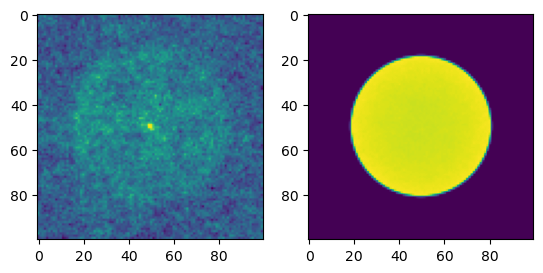

In [21]:
fig = plt.subplot(121)
fig.imshow(flux.mean)
fig2 = plt.subplot(122)
fig2.imshow(fission.mean)

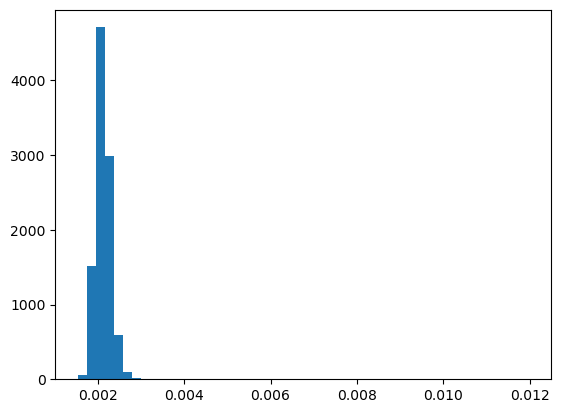

In [22]:
# Determine relative error
relative_error = np.zeros_like(flux.std_dev)
nonzero = flux.mean > 0
relative_error[nonzero] = flux.std_dev[nonzero] / flux.mean[nonzero]

# distribution of relative errors
ret = plt.hist(relative_error[nonzero], bins=50)

In [23]:
sp.source

array([(( 0.08772347,  0.23962742,  0.29253484), ( 0.11192012,  0.96126467,  0.25188117), 1887586.87150515, 0.00371698, 1., 0, 0, 0),
       (( 0.08772347,  0.23962742,  0.29253484), (-0.59603157,  0.56261908,  0.57289278), 3152813.90086673, 0.00371698, 1., 0, 0, 0),
       (( 0.16819629,  0.15701477,  0.17616403), ( 0.65352264, -0.42024906, -0.62952275), 2290552.9522575 , 0.00367952, 1., 0, 0, 0),
       ...,
       ((-0.05081032,  0.30106619,  0.41757803), (-0.54467069,  0.70638327, -0.45205809), 2367254.35375201, 0.00368179, 1., 0, 0, 0),
       (( 0.07436649, -0.1727035 , -0.14723158), (-0.95927511, -0.1922085 , -0.20699555), 1110741.65060736, 0.0035214 , 1., 0, 0, 0),
       (( 0.07436649, -0.1727035 , -0.14723158), (-0.24112042, -0.79879083, -0.55117524),  829182.14951589, 0.0035214 , 1., 0, 0, 0)],
      dtype={'names': ['r', 'u', 'E', 'time', 'wgt', 'delayed_group', 'surf_id', 'particle'], 'formats': [[('x', '<f8'), ('y', '<f8'), ('z', '<f8')], [('x', '<f8'), ('y', '<f8'), ('z'

In [24]:
sp.source['E']

array([1887586.87150515, 3152813.90086673, 2290552.9522575 , ...,
       2367254.35375201, 1110741.65060736,  829182.14951589])

1.0


Text(0, 0.5, 'Probability/eV')

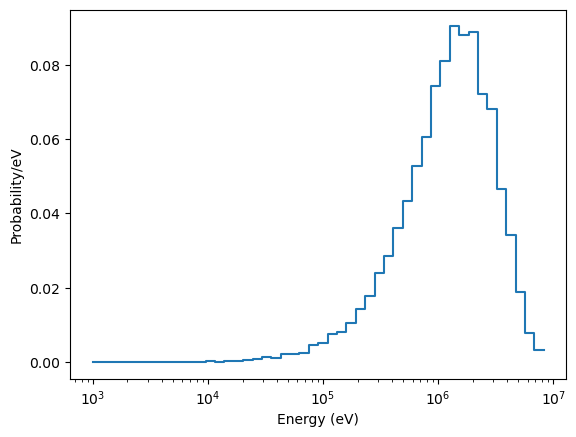

In [25]:
# Create log-spaced energy bins from 1 keV to 10 MeV
energy_bins = np.logspace(3,7)

# Calculate pdf for source energies
probability, bin_edges = np.histogram(sp.source['E'], energy_bins, density=True)

# Make sure integrating the PDF gives us unity
print(sum(probability*np.diff(energy_bins)))

# Plot source energy PDF
plt.semilogx(energy_bins[:-1], probability*np.diff(energy_bins), drawstyle='steps')
plt.xlabel('Energy (eV)')
plt.ylabel('Probability/eV')

(-0.5, 0.5)

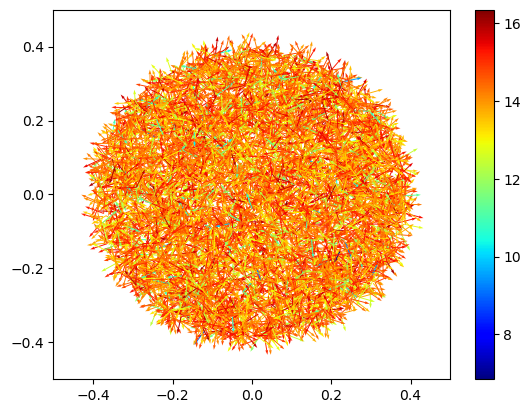

In [26]:
plt.quiver(sp.source['r']['x'], sp.source['r']['y'],
           sp.source['u']['x'], sp.source['u']['y'],
           np.log(sp.source['E']), cmap='jet', scale=20.0)
plt.colorbar()
plt.xlim((-0.5,0.5))
plt.ylim((-0.5,0.5))

In [27]:
# Close the statepoint file as a matter of best practice
sp.close()